In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:

train_dir = "train"
validation_dir = "test"

BATCH_SIZE = 32
IMG_SIZE = (64, 64)

train_dataset = image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, label_mode='categorical'
)


validation_dataset = image_dataset_from_directory(
    validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, label_mode='categorical'
)


class_names = train_dataset.class_names


Found 6000 files belonging to 5 classes.
Found 2000 files belonging to 5 classes.


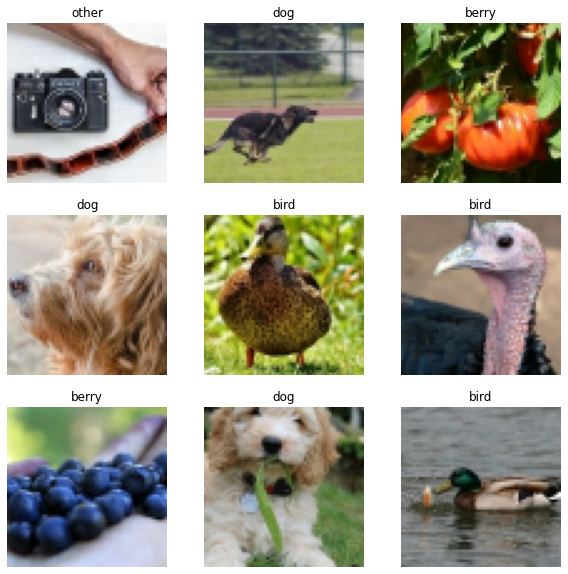

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    labels = labels._numpy().argmax(1)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Number of validation batches: 51
Number of test batches: 12


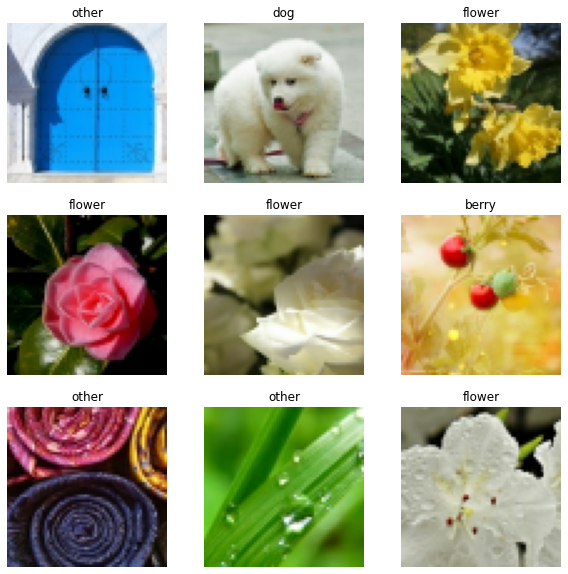

In [4]:

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    labels = labels._numpy().argmax(1)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


print("Number of validation batches: %d" % tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))


data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)


(32, 2, 2, 1280)


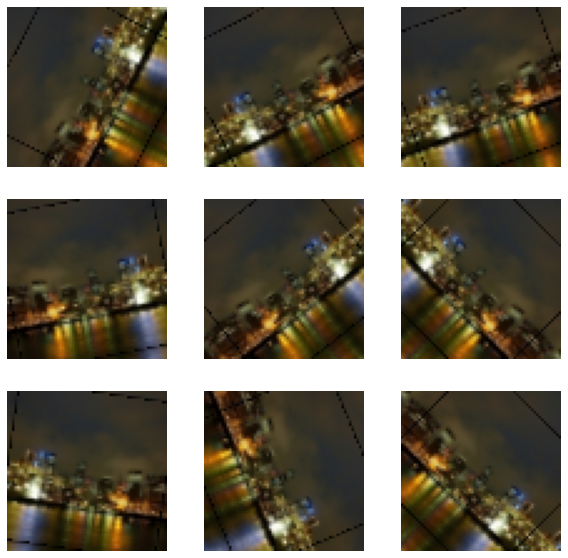

In [5]:


for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 127.5, offset=-1)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False


In [6]:
class_names

['berry', 'bird', 'dog', 'flower', 'other']

In [7]:
tf.constant(0.2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.2>

In [8]:
np.__version__

'1.19.5'

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()
len(model.trainable_variables)

(32, 1280)
(32, 5)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 3)         0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 64, 64, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None,

2

51/51 [==============================] - 5s 100ms/step - loss: 2.5653 - accuracy: 0.2339
initial loss: 2.57
initial accuracy: 0.23
Epoch 1/10
188/188 [==============================] - 24s 130ms/step - loss: 1.8546 - accuracy: 0.3533 - val_loss: 1.4317 - val_accuracy: 0.4722
Epoch 2/10
188/188 [==============================] - 18s 97ms/step - loss: 1.3477 - accuracy: 0.4985 - val_loss: 1.0873 - val_accuracy: 0.5959
Epoch 3/10
188/188 [==============================] - 17s 92ms/step - loss: 1.1347 - accuracy: 0.5773 - val_loss: 0.9197 - val_accuracy: 0.6541
Epoch 4/10
188/188 [==============================] - 17s 93ms/step - loss: 1.0339 - accuracy: 0.6103 - val_loss: 0.8137 - val_accuracy: 0.6962
Epoch 5/10
188/188 [==============================] - 18s 93ms/step - loss: 0.9132 - accuracy: 0.6552 - val_loss: 0.7399 - val_accuracy: 0.7215
Epoch 6/10
188/188 [==============================] - 18s 94ms/step - loss: 0.8766 - accuracy: 0.6675 - val_loss: 0.7139 - val_accuracy: 0.7296
Epoc

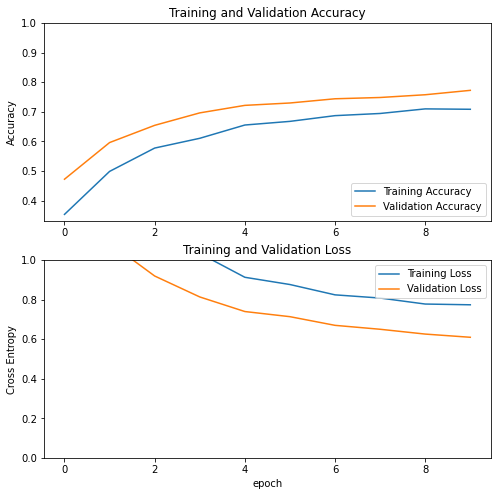

Number of layers in the base model:  155


In [12]:

initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)


acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()


base_model.trainable = True


print("Number of layers in the base model: ", len(base_model.layers))


fine_tune_at = 100


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10),
    metrics=["accuracy"],
)

In [14]:
len(model.trainable_variables)
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

In [16]:

history_fine = model.fit(
    train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset
)

Epoch 10/20
188/188 [==============================] - 28s 148ms/step - loss: 0.5883 - accuracy: 0.7787 - val_loss: 0.4447 - val_accuracy: 0.8311
Epoch 11/20
188/188 [==============================] - 28s 148ms/step - loss: 0.5503 - accuracy: 0.7962 - val_loss: 0.4132 - val_accuracy: 0.8521
Epoch 12/20
188/188 [==============================] - 28s 150ms/step - loss: 0.5183 - accuracy: 0.8080 - val_loss: 0.3723 - val_accuracy: 0.8645
Epoch 13/20
188/188 [==============================] - 28s 150ms/step - loss: 0.4989 - accuracy: 0.8150 - val_loss: 0.3710 - val_accuracy: 0.8670
Epoch 14/20
188/188 [==============================] - 29s 153ms/step - loss: 0.4715 - accuracy: 0.8202 - val_loss: 0.3746 - val_accuracy: 0.8626
Epoch 15/20
188/188 [==============================] - 27s 145ms/step - loss: 0.4374 - accuracy: 0.8350 - val_loss: 0.3570 - val_accuracy: 0.8725
Epoch 16/20
188/188 [==============================] - 28s 150ms/step - loss: 0.4289 - accuracy: 0.8413 - val_loss: 0.3664 -

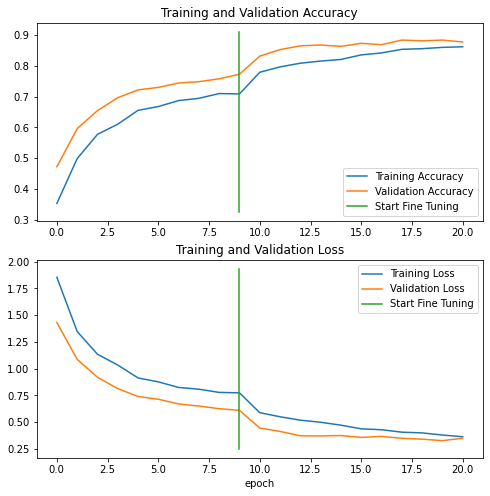

In [17]:

acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

12/12 [==============================] - 1s 77ms/step - loss: 0.3283 - accuracy: 0.8932
Test accuracy : 0.8932291865348816
Predictions:
 [0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1
 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0
 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0
 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0
 0 0 0 1 1 0 0 0 0 0 1 0]
Labels:
 [[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0

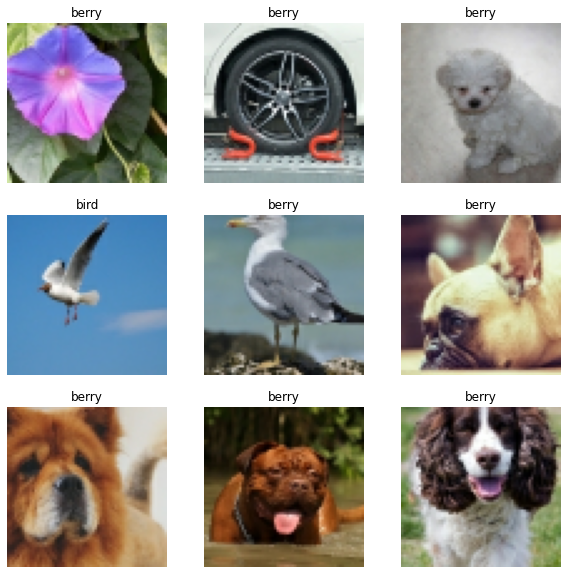

In [18]:


loss, accuracy = model.evaluate(test_dataset)
print("Test accuracy :", accuracy)


image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()


predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")



In [21]:
model.save('savedmodel')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: savedmodel\assets


In [22]:
dbg = tf.keras.models.load_model('savedmodel')

In [23]:
dbg.evaluate(test_dataset)

12/12 [==============================] - 1s 87ms/step - loss: 0.3126 - accuracy: 0.9036


[0.3125688135623932, 0.9036458134651184]